In [1]:
import numpy as np
import pandas as pd
import re

#### Word2Vec
import gensim
from gensim.models import Word2Vec

from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('save_true.csv', index_col='Unnamed: 0')
df

,Content,Target
0,блеф» один мой самый любимый комедия фильм нав...,Good
1,адриано челентано продолжать радовать свой раб...,Good
2,несомненно это великий фильм 80х год исключите...,Good
3,этот фраза взгляд отражать сюжет несомненно пр...,Good
4,петь земфира скорее совершенно другой повод «ф...,Neutral
...,...,...
36586,начать… давненько писать отрицательный рецензи...,Bad
36587,начать постер фильм «цветок дьявола» вызывать ...,Bad
36588,фильм производство россия поэтому многие ожида...,Good
36589,16 сентябрь больший экран выйти «мистический» ...,Bad


In [3]:
def clean_txt_2(text):
    text = re.sub(r'[^а-яё\s]', '', text)
    return text

In [4]:
df['clean_cont'] = df['Content'].apply(clean_txt_2)

In [5]:
def get_words_by_freq(sorted_words: list[tuple[str, int]], n: int = 10) -> list:
    return list(filter(lambda x: x[1] > n, sorted_words))

In [6]:
preproc = df['clean_cont'].tolist()

#Анализируем частоты слов и выбираем только часто встречаемые (выше порога)

corpus = [word for text in preproc for word in text.split()]
sorted_words = Counter(corpus).most_common()

porog = 30

sorted_words = get_words_by_freq(sorted_words, porog)

In [7]:
sorted_words[-10:]

[('анфиса', 31),
 ('уилль', 31),
 ('доцент', 31),
 ('жён', 31),
 ('герд', 31),
 ('киносвидание', 31),
 ('вий', 31),
 ('вия', 31),
 ('штольня', 31),
 ('суперменеджер', 31)]

In [8]:
len(sorted_words)

13942

In [9]:
# Создаем словарь слово: индекс
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

In [10]:
# Конвертируем слова в индексы
reviews_int = []
for text in preproc:
    r = [vocab_to_int[word] for word in text.split() if vocab_to_int.get(word)]
    reviews_int.append(r)
print([i for i in reviews_int[0]])
print(preproc[0])

[11470, 12, 61, 15, 126, 225, 1, 959, 17, 1317, 47, 28, 1408, 4, 1129, 35, 1019, 131, 1, 247, 7678, 4688, 3, 143, 2, 10, 20, 25, 123, 13, 523, 5895, 776, 2131, 6386, 422, 230, 922, 64, 5896, 4796, 1015, 27, 355, 13, 1203, 4, 2131, 3786, 4688, 1988, 4, 66, 3434, 458, 1080, 131, 300, 86, 696, 7678, 663, 137, 55, 2298, 15, 9838, 385, 1063, 17, 881, 347, 13454, 12, 83, 24, 511, 12, 4, 1, 2617, 829, 20, 1280, 12, 60, 8778, 2583, 1839, 212, 1385, 5616, 220, 1302, 54, 7244, 3, 471, 5584, 14, 3564, 1839, 7, 24, 55, 154, 13, 1, 152, 3, 1205, 9117, 6540, 1393, 6540, 460, 5719, 309, 5015, 2583, 156, 5063, 4, 1689, 560, 5617, 4380, 3, 4362, 13455, 826, 441, 500, 256, 10526, 8697, 5719, 10527, 224, 1045, 1281, 3435, 300, 60, 333, 38, 809, 1603, 8, 2085, 89, 678, 11470, 4689, 18, 562, 1069, 86, 11025, 11627, 11470, 140, 60, 2602, 735, 1701, 161, 60, 2355, 11471, 4073, 3963, 2178, 3394, 2339, 606, 60, 3, 3195, 1087, 55, 809, 1588, 265, 2291, 22, 2, 123, 25, 17, 474, 6, 293, 465, 4, 2116, 1936]
блеф о

In [11]:
w2v_input = []
for review in preproc:
    cur_review = []
    for word in review.split():
        if vocab_to_int.get(word):
            cur_review.append(word)
    w2v_input.append(cur_review)
print(f'Total reviews: {len(w2v_input)}')
print(f'Random review for word2vec: {w2v_input[np.random.randint(0, 30000)]}')

Total reviews: 36591
Random review for word2vec: ['убрать', 'моцарт', 'один', 'нота', 'желание', 'вернуть', 'её', 'место', 'преследовать', 'каждый', 'прослушивание', 'напротив', 'добавить', 'один', 'лишний', 'вырезать', 'й', 'минута', 'начала', 'хотя', 'один', 'сцена', 'её', 'хватать', 'добавить', 'диалог', 'яркий', 'краска', 'сюжет', 'быть', 'разбавить', 'каждый', 'следующий', 'минута', 'фильм', 'дополнять', 'какойтый', 'степень', 'картина', 'каждый', 'прошедший', 'минута', 'наполнять', 'краска', 'следующий', 'последовательно', 'переходить', 'она', 'огромный', 'количество', 'пища', 'размышление', 'смесь', 'фильм', 'напоминать', 'первый', 'матрицу', 'схожесть', 'этот', 'шедевр', 'заканчиваться', 'сравнимый', 'послевкусие', 'уникальный', 'палитра', 'вкус', 'желание', 'ощутить', 'ещё', 'ещё', 'смотреть', 'следующий', 'такой', 'уникальный', 'кристофер', 'нолан', 'ханс', 'циммер', 'подарить', 'человечество', 'фильм', 'вкус', 'который', 'невозможно', 'забыть', 'выделяться', 'общий', 'масса'

In [12]:
VOCAB_SIZE = len(vocab_to_int) + 1
EMBEDDING_DIM = 128

In [13]:
#Обучим Word2Vec
wv = Word2Vec(
    vector_size=EMBEDDING_DIM # размерность вектора для слова
    )
# Сначала word2vec составляет словарь
wv.build_vocab(w2v_input)
print(f'Total reviews: {wv.corpus_count}')

Total reviews: 36591


In [14]:
# Далее обучаем
wv.train(
    corpus_iterable=w2v_input,
    total_examples=wv.corpus_count,
    epochs=30
    );

In [50]:
wv

In [15]:
# Создаем слой эмбеддинга
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Бежим по всем словам словаря: если слово есть в word2vec, 
# достаем его вектор; если слова нет, то распечатываем его и пропускаем
for word, i in vocab_to_int.items():
    try:
        embedding_vector = wv.wv[word]
        embedding_matrix[i] = embedding_vector
    except KeyError as e:
        pass
        print(f'{e}: word: {word}')
        
# Создаем предобученный эмбеддинг – этот слой в нашей сети обучаться не будет
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
print(f'Number of words x EMEDDING_DIM: {embedding_matrix.shape}')

Number of words x EMEDDING_DIM: (13943, 128)


In [16]:
HIDDEN_SIZE = 32
SEQ_LEN = 80
BATCH_SIZE = 256

In [17]:
def padding(review_int, seq_len):
    features = np.zeros((len(review_int), seq_len), dtype=int)

    for i, review in enumerate(review_int):
        if not isinstance(review, list):
            raise ValueError(f"Ошибка: ожидался список, но получено {type(review)}")
        if len(review) == 0:
            continue  
        features[i, -min(len(review), seq_len):] = np.array(review[:seq_len])
    
    return features

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#Закодируем таргет
encoder = LabelEncoder()
target = encoder.fit_transform(df['Target'])

In [19]:
padded = padding(reviews_int, SEQ_LEN) 
y = np.array(target)

In [20]:
X = np.array(padded)

In [21]:
#### делаем балансировку классов с помощью SMOTE

#sm = SMOTE(random_state=42)
#X_bal, y_bal = sm.fit_resample(X, y)

### Не сработало, плохие метрики

In [22]:
#делаем другое
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.array([0, 1, 2]), 
                                     y=target)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [23]:
unique_values, counts = np.unique(target, return_counts=True)

# Выводим результат
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 4751
1: 27264
2: 4576


In [24]:
class_weights

tensor([2.5672, 0.4474, 2.6654])

In [25]:
#### Делаем даталодер

class LSTMDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.FloatTensor(y)  # для бинарной классификации
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [27]:
train_data = LSTMDataset(X_train, y_train)
valid_data = LSTMDataset(X_valid, y_valid)
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE)

In [28]:
class BahdanauAttention(nn.Module):
    def __init__(
            self, 
            hidden_size: int = HIDDEN_SIZE
            ) -> None:
        
        super().__init__()
        self.hidden_size = hidden_size
        self.w_k = nn.Linear(self.hidden_size, self.hidden_size)
        self.w_q = nn.Linear(self.hidden_size, self.hidden_size)
        self.tanh   = nn.Tanh()
        self.w_v = nn.Linear(self.hidden_size, 1)

        # self.align  = nn.Linear(self.hidden_size * 2, self.hidden_size)

    def forward(
            self, 
            lstm_outputs: torch.Tensor, # BATCH_SIZE x SEQ_LEN x HIDDEN_SIZE
            final_hidden: torch.Tensor  # BATCH_SIZE x HIDDEN_SIZE
            ):
        att_hidden_left = self.w_k(lstm_outputs)
        att_hidden_right = self.w_q(final_hidden)
        summ = att_hidden_left + att_hidden_right.unsqueeze(1)
        after_tanh = self.tanh(summ)
        output = self.w_v(after_tanh)
        attention_weights = F.softmax(output, dim=1)
        context = torch.bmm(attention_weights.transpose(1,2), att_hidden_left)
 
        return context, attention_weights

In [29]:
class LSTMConcatAttention(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # self.embedding = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(EMBEDDING_DIM, HIDDEN_SIZE, batch_first=True)
        self.attn = BahdanauAttention(HIDDEN_SIZE)
        self.clf = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, 128),
            nn.Dropout(),
            nn.Tanh(),
            nn.Linear(128, 3)
        )
    
    def forward(self, x):
        embeddings = self.embedding(x)
        outputs, (h_n, _) = self.lstm(embeddings)
        att_hidden, att_weights = self.attn(outputs, h_n.squeeze(0))
        out = self.clf(att_hidden)
        return out, att_weights

In [30]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [31]:
attention = BahdanauAttention(HIDDEN_SIZE)
model = LSTMConcatAttention().to(DEVICE)
device = DEVICE
criterion = torch.nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
from sklearn.metrics import f1_score

In [41]:
def fit(model: torch.nn.Module, 
        n_epochs: int, 
        train_loader: DataLoader,
        valid_loader: DataLoader,
        optimizer: torch.optim.Optimizer,
        device: torch.device,
        log = None):
    
    log = log or {
        'epoch_train_loss': [],
        'epoch_valid_loss': [],
        'epoch_train_f1': [],
        'epoch_valid_f1': [],
    }

    start_epoch = len(log['epoch_train_loss'])

    for epoch in range(start_epoch+1, start_epoch+n_epochs+1):
            
        print(f'{"-"*38} Epoch  {epoch}/{n_epochs} {"-"*38}')
        batch_loss = []
        batch_f1 = []
        model.train()

        for X_batch, y_batch in train_loader:
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs, _ = model(X_batch)  # outputs: [batch_size, num_classes]
            outputs = outputs.squeeze(1)
            loss = F.cross_entropy(outputs, y_batch.squeeze().long())
            preds = torch.argmax(outputs, dim=1)

            # Вычисляем F1
            f1 = f1_score(y_batch.cpu().numpy(), preds.cpu().numpy(), average='weighted')

            batch_loss.append(loss.item())
            batch_f1.append(f1)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        log['epoch_train_loss'].append(np.mean(batch_loss))
        log['epoch_train_f1'].append(np.mean(batch_f1))

        # Валидация
        batch_loss = []
        batch_f1 = []
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch = X_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)

                outputs, _ = model(X_batch)
                outputs = outputs.squeeze(1)
                loss = F.cross_entropy(outputs, y_batch.squeeze().long())

                preds = torch.argmax(outputs, dim=1)
                f1 = f1_score(y_batch.cpu().numpy(), preds.cpu().numpy(), average='weighted')

                batch_loss.append(loss.item())
                batch_f1.append(f1)

        log['epoch_valid_loss'].append(np.mean(batch_loss))
        log['epoch_valid_f1'].append(np.mean(batch_f1))

        print(f"Train stage: loss: {log['epoch_train_loss'][-1]:.3f} f1: {log['epoch_train_f1'][-1]:.3f}")
        print(f"Valid stage: loss: {log['epoch_valid_loss'][-1]:.3f} f1: {log['epoch_valid_f1'][-1]:.3f}")

    return log 

In [34]:
#criterion = torch.nn.CrossEntropyLoss(weight=class_weights).to(device)
#model1 = LSTMConcatAttention().to(DEVICE)
#optimiz = torch.optim.Adam(model1.parameters(), lr=0.001)

In [35]:
#lstm2 = fit(
   # model=model1,
    #n_epochs=7,
    #train_loader=train_loader,
    #valid_loader=valid_loader,
    #optimizer=optimiz,
    #device=DEVICE
    #)

In [42]:
lstm = fit(
    model=model,
    n_epochs=2,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    device=DEVICE
    )

-------------------------------------- Epoch  1/2 --------------------------------------
Train stage: loss: 0.487 f1: 0.773
Valid stage: loss: 0.530 f1: 0.758
-------------------------------------- Epoch  2/2 --------------------------------------
Train stage: loss: 0.470 f1: 0.784
Valid stage: loss: 0.536 f1: 0.765


In [43]:
lstm = fit(
    model=model,
    n_epochs=3,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    device=DEVICE,
    log=lstm
    )

-------------------------------------- Epoch  3/3 --------------------------------------
Train stage: loss: 0.455 f1: 0.793
Valid stage: loss: 0.541 f1: 0.766
-------------------------------------- Epoch  4/3 --------------------------------------
Train stage: loss: 0.439 f1: 0.805
Valid stage: loss: 0.557 f1: 0.769
-------------------------------------- Epoch  5/3 --------------------------------------
Train stage: loss: 0.426 f1: 0.811
Valid stage: loss: 0.570 f1: 0.777


Text(0.5, 1.0, 'F1 score')

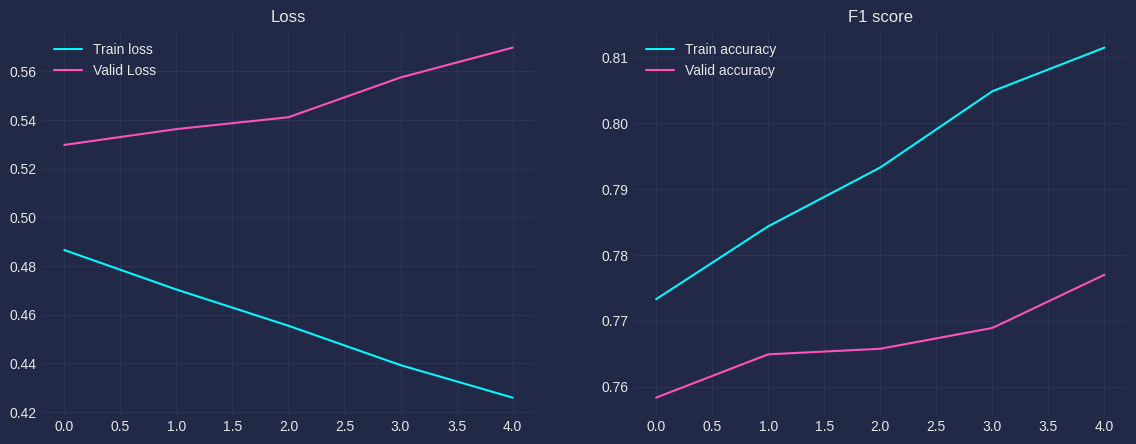

In [44]:
import matplotlib.pyplot as plt
import mplcyberpunk
plt.style.use("cyberpunk")

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(lstm['epoch_train_loss'], label='Train loss')
ax[0].plot(lstm['epoch_valid_loss'], label='Valid Loss')
ax[0].legend()
ax[0].set_title('Loss')

ax[1].plot(lstm['epoch_train_f1'], label='Train accuracy')
ax[1].plot(lstm['epoch_valid_f1'], label='Valid accuracy')
ax[1].legend()
ax[1].set_title('F1 score')

In [49]:
print(f'F1 score on LSTN+Attention: {max(lstm["epoch_valid_f1"])}')

F1 score on LSTN+Attention: 0.77698106405946


In [45]:
torch.save(model.state_dict(), './nlp_project/models/model_1/lstm/lstm.pt')

In [51]:
wv.save('/home/marena/Elbrus_phase_2/nlp_project/models/model_1/lstm/w2v.model')